# Identify Brute-Force Login Attack
I'd like to demonstrate my analytical skills and thought process by working through an analysis of a website's authentication log to identify whether the website was subject to a brute-force login attack.

I searched the web for a dataset to analyze and came across a .txt file containing authentication log records for a small website, which someone posted online with the question, "Am I experiencing a brute force attack?" (source: https://security.stackexchange.com/questions/110706/am-i-experiencing-a-brute-force-attack)

I then did some data exploration and visualization on the data to identify whether and when an attack was happening, and which IP addresses seemed problematic.

**Disclaimer:** The following is only one "quick and dirty" way to approach this problem. The level of sophistication can be tailored to the scope of the analysis and to the type of data that is available for querying.

## Step 1 - Find and Clean the Data

In [1]:
# basic imports
from pathlib import Path
import pandas as pd
import re
import altair as alt

The `auth.log` data I found is a text file containing the authentication log for a website. Before running any analysis on it I need to convert the data from unstructured text to a structured dataset.

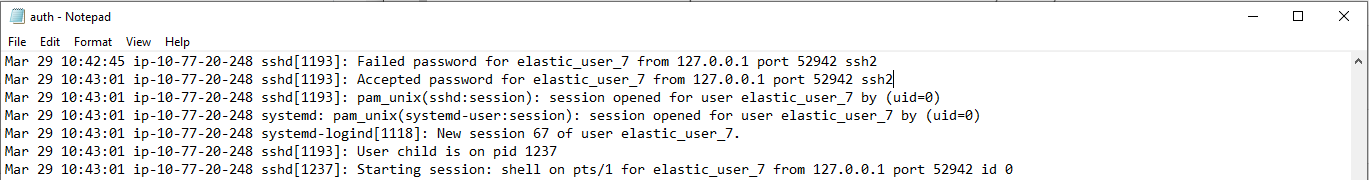

I scrolled through the data and found that regular expressions will help to extract the date, username, ip address, and help to identify whether the login attempt was successful or failed.

In [2]:
# capture data for failed logins
failed_pattern = re.compile(
    r"""
        ^                                              # Beginning of string
        (?P<timestamp>\w{3}\s\d{2}\s\d{2}:\d{2}:\d{2}) # Timestamp
        .+                                             # At last one misc character
        Failed\spassword\sfor\s                        # Failed password
        (?P<username>.+)                               # username of login attempt
        \sfrom\s
        (?P<ip_address>[\d|.]+)                        # i.p. address for user attempt
    """,
    re.VERBOSE)

In [3]:
# capture data for accepted logins
accepted_pattern = re.compile(
    r"""
        ^                                              # Beginning of string
        (?P<timestamp>\w{3}\s\d{2}\s\d{2}:\d{2}:\d{2}) # Timestamp
        .+                                             # At last one misc character
        Accepted\spassword\sfor\s                      # Accepted password
        (?P<username>.+)                               # username of login attempt
        \sfrom\s
        (?P<ip_address>[\d|.]+)                        # i.p. address for user attempt
    """,
    re.VERBOSE)

In [4]:
# instantiate empty lists to hold data
timestamp_list = []
username_list = []
ip_list = []
flag_list = []

# open the file and run through every line
loc = Path.cwd().parent / 'data' / 'auth.log'
with open(loc) as file:
    
    for line in file:
        
        # check if failed_pattern matched, and save data
        if re.match(failed_pattern, line) is not None:
            result = re.match(failed_pattern, line)
            timestamp_list += [result.group('timestamp')]
            username_list += [result.group('username')]
            ip_list += [result.group('ip_address')]
            flag_list += ['failed']
            pass
        
        # check if accepted_pattern matched, and save data
        elif re.match(accepted_pattern, line) is not None:
            result = re.match(accepted_pattern, line)
            timestamp_list += [result.group('timestamp')]
            username_list += [result.group('username')]
            ip_list += [result.group('ip_address')]
            flag_list += ['accepted']
            pass
        
        # if no match for accepted or failed, skip the record
        else:
            pass

Now I have a few lists of data extracted from the `auth.log` file:

In [5]:
print('First few records of each structured list:')
print('\t', 'timestamps:', timestamp_list[:3])
print('\t', 'usernames:', username_list[:3])
print('\t', 'ip addresses:', ip_list[:3])
print('\t', 'login attempt flag:', flag_list[:3])

First few records of each structured list:
	 timestamps: ['Mar 29 10:42:45', 'Mar 29 10:43:01', 'Mar 29 11:35:20']
	 usernames: ['elastic_user_7', 'elastic_user_7', 'elastic_user_2']
	 ip addresses: ['127.0.0.1', '127.0.0.1', '85.245.107.41']
	 login attempt flag: ['failed', 'accepted', 'accepted']


This is great, but workign with separate lists can get messy, so I'd rather put these lists in a pandas dataframe to make the data easier to work with.

In [6]:
# instantiate empty DataFrame
df = pd.DataFrame()

# populated with cleaned log data
df['timestamp'] = timestamp_list
df['username'] = username_list
df['ip_address'] = ip_list
df['flag'] = flag_list

As a small bit of housekeeping, I need to add the year to the timestamp data in order to make timeseries functions work later on.

In [7]:
# set timestamp column to datetime data-type
# need to insert year for the function to work
df['timestamp'] = pd.to_datetime(df['timestamp'].str[:6] + ', 2021' + df['timestamp'].str[6:])

Here is a preview of the first five records in this clean dataset.

In [8]:
df.head()

,timestamp,username,ip_address,flag
0,2021-03-29 10:42:45,elastic_user_7,127.0.0.1,failed
1,2021-03-29 10:43:01,elastic_user_7,127.0.0.1,accepted
2,2021-03-29 11:35:20,elastic_user_2,85.245.107.41,accepted
3,2021-03-29 11:36:51,elastic_user_8,85.245.107.41,accepted
4,2021-03-29 11:37:37,elastic_user_5,85.245.107.41,accepted


Sweet structured data - much better!

## Step 2 - Analyze the Data

Now that everything is in an easy-to-digest format I can quickly get a sense of what kind of data I'm working with. 

The two descriptive functions below tell me that I have `634` records in the dataset, consisting of the login attempts I extracted out of the `auth.log` file: `timestamp`, `username`, `ip_address`, and `flag`, which indicates whether the login attempt was successful or failed.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   634 non-null    datetime64[ns]
 1   username    634 non-null    object        
 2   ip_address  634 non-null    object        
 3   flag        634 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 19.9+ KB


I'd like to see the successful vs failed login attempts by hour on a chart to quickly identify if I can spot any fishy login activity in the time series data.

In [10]:
# to visualize logins by hour, need to group timestamps by hour and add a login attempt count column
df['hourly'] = pd.to_datetime(df['timestamp'].dt.strftime('%Y-%m-%d %H:00:00'))
df['count'] = 1

In [11]:
# create a dataframe that holds the data necessary to plot
hourly_count = df.groupby(['flag', 'hourly'], as_index=False).agg({'count':sum})

In [21]:
# The basic line
line = alt.Chart(hourly_count).mark_line(interpolate='basis').encode(
    x='hourly:T',
    y='count:Q',
    color='flag:N'
)

line;

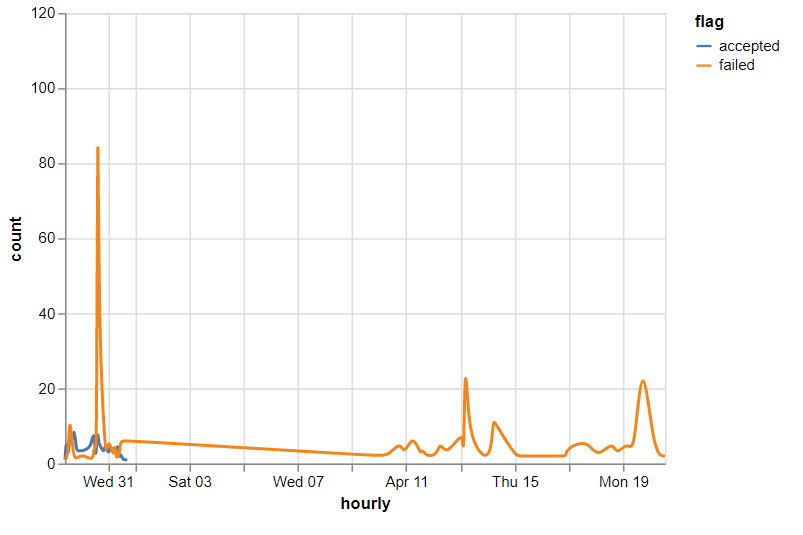

This particular dataset has very little traffic on a regular basis. We can see that failed logins vastly outnumber successful logins, with three distinct periods of concentrated failed logins, which look fishy: 

* March 30th
* April 13th
* April 19th

I'd like to dig further into failed logins on these dates to identify the particular IP addresses involved. To do that I need to get a more precise time period of activity where the brute-force attack is happening.

In [13]:
failed_by_hour = (
    hourly_count.loc[hourly_count['flag'] == 'failed']
    .sort_values('count', ascending=False)
)

In [14]:
failed_by_hour.head()

,flag,hourly,count
54,failed,2021-03-30 15:00:00,117
104,failed,2021-04-19 17:00:00,32
55,failed,2021-03-30 16:00:00,32
80,failed,2021-04-13 04:00:00,30
44,failed,2021-03-29 14:00:00,14


This table shows precisely when suspected brute-force login attempts happened.

I will zoom in to failed login attempts on March 30th between 15:00 and 16:00 to identify malicious IP addresses. To zoom in I'm creating a separate dataset of activity during this time period, called `attack_df`.

In [15]:
min_period = df['hourly'] >= '2021-03-30 15:00'
max_period = df['hourly'] <= '2021-03-30 16:00'
attack_df = df.loc[min_period & max_period].copy()

In [16]:
# Here is a preview of this data
attack_df.head()

,timestamp,username,ip_address,flag,hourly,count
133,2021-03-30 15:07:56,elastic_user_6,24.151.103.17,accepted,2021-03-30 15:00:00,1
134,2021-03-30 15:17:24,elastic_user_9,85.245.107.41,accepted,2021-03-30 15:00:00,1
135,2021-03-30 15:23:09,elastic_user_9,24.151.103.17,accepted,2021-03-30 15:00:00,1
136,2021-03-30 15:29:17,elastic_user_8,85.245.107.41,failed,2021-03-30 15:00:00,1
137,2021-03-30 15:29:20,elastic_user_8,85.245.107.41,failed,2021-03-30 15:00:00,1


In [17]:
# How many failed vs accepted logins during this time period?
attack_df['flag'].value_counts()

failed      149
accepted     14
Name: flag, dtype: int64

During this time period there are 149 failed login attempts and 14 successful login attempts. I want to zoom in on the failed attempts to see which distinct IP addresses are responsible for the attempts.

In [18]:
attack_df.loc[attack_df['flag'] == 'failed', 'ip_address'].value_counts()

24.151.103.17    147
85.245.107.41      2
Name: ip_address, dtype: int64

`24.151.103.17` is a highly suspicious IP address due to 147 failed login attempts in a 2-hour block. Should we block this IP address outright? What does this IP address's activity look like during all time periods?

In [19]:
df.loc[df['ip_address'] == '24.151.103.17', 'flag'].value_counts()

failed      157
accepted     47
Name: flag, dtype: int64

There are 47 successful login attempts and 157 failed attempts. So we wouldn't want to immediately block this IP address since there are successful logins, and we might inadvertantly block legitimate users. We would want to deal with the IP address in such a way as to not block real users from accessing our site.

Another interesting perspective is to look at patterns aroudn which usernames are responsible for failed login attempts.

In [20]:
df.loc[df['flag'] == 'failed', 'username'].value_counts()

elastic_user_0          148
root                    130
invalid user admin       81
invalid user ubnt        27
invalid user pi          18
invalid user ajay         6
invalid user cloud        6
invalid user pruebas      6
invalid user openerp      6
elastic_user_8            4
elastic_user_7            3
elastic_user_3            3
elastic_user_2            3
elastic_user_5            3
elastic_user_6            2
elastic_user_4            1
elastic_user_9            1
elastic_user_1            1
Name: username, dtype: int64

Overall `elastic_user_0` and `root` are have the most failed login activity. Also the invalid username `admin` was tried 81 times. This is a further indication that someone is maliciously trying to login to the website. Steps can be taken to make sure these two users have strong passwords.

## Summary
* Was this website subject to a brute force attack? 
    * Yes, potentially on three occasions. This is clear from spikes in failed login activity on three occasions, combined with the fact that two usernames with the most failed logins are `root` and `admin`.
* Which IP address was responsible? 
    * `24.151.103.17` - but this IP address is also responsible for legitimate logins, so we can't block it outright, but we can monitor it for further activity.